<a href="https://colab.research.google.com/github/EdwinAR99/TalentoTECH-Repo/blob/master/Convolution_CIFAR_TalentoTECH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORT LIBS

In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from keras import datasets
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from keras.initializers import RandomNormal, Constant

from keras.preprocessing.image import ImageDataGenerator

#LIBERAR RAM

In [ ]:
# Garbage Collector - use it like gc.collect()
import gc

# Custom Callback To Include in Callbacks List At Training Time
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

# LOAD DATASETS

In [2]:
# Cargar los conjuntos de datos CIFAR-10 y CIFAR-100
(x_train_10, y_train_10), (x_test_10, y_test_10) = datasets.cifar10.load_data()
(x_train_100, y_train_100), (x_test_100, y_test_100) = datasets.cifar100.load_data()

169001437/169001437 [==============================] - 2s 0us/step


In [3]:
# Cargar los nombres de las clases para CIFAR-10 y CIFAR-100
cifar10_class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
cifar100_class_names = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

In [4]:
# Normalizar los datos de píxeles a un rango entre 0 y 1
x_train_10, x_test_10 = x_train_10 / 255.0, x_test_10 / 255.0
x_train_100, x_test_100 = x_train_100 / 255.0, x_test_100 / 255.0

# DEFAULT FUNCTIONS

In [5]:
# Definir el modelo CNN mejorado
def create_cnn10_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(64,(4,4),input_shape=input_shape,activation='relu'))
    model.add(Conv2D(64,(4,4),input_shape=input_shape,activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.4))
    model.add(Conv2D(128,(4,4),input_shape=input_shape,activation='relu'))
    model.add(Conv2D(128,(4,4),input_shape=input_shape,activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(1024,activation='relu'))
    model.add(Dense(1024,activation='relu'))
    model.add(Dense(units = num_classes, activation = 'softmax'))
    return model

In [6]:
def create_cnn100_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(256, (3,3), padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization(momentum=0.95,
                                 epsilon=0.005,
                                 beta_initializer=RandomNormal(mean=0.0, stddev=0.05),
                                 gamma_initializer=Constant(value=0.9)))
    model.add(Dense(num_classes, activation='softmax'))

    return model

In [7]:
# Función para visualizar la precisión y la pérdida
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

In [8]:
# Función para mostrar ejemplos de imágenes de prueba junto con las etiquetas reales y las predicciones del modelo
def show_examples(images, labels, predictions, class_names):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(int(len(predictions)/5), 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        actual_label = class_names[labels[i][0]]
        predicted_label = class_names[np.argmax(predictions[i])]
        if actual_label == predicted_label:
            color = 'green'
        else:
            color = 'red'
        plt.xlabel(f"Actual: {actual_label}\nPredicted: {predicted_label}", color=color)
    plt.show()

# BUILD MODEL CIFAR10

In [ ]:
# Crear el modelo CIFAR-10
cifar10_model = create_cnn10_model(x_train_10.shape[1:], 10)

In [ ]:
# Compilar el modelo CIFAR-10
cifar10_model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

In [ ]:
# Entrenar el modelo CIFAR-10
cifar10_history = cifar10_model.fit(x_train_10, y_train_10, epochs=20, verbose=1, validation_data=(x_test_10, y_test_10))

Epoch 1/20
1563/1563 [==============================] - 17s 9ms/step - loss: 1.7274 - accuracy: 0.3549 - val_loss: 1.4065 - val_accuracy: 0.4843
Epoch 2/20
1563/1563 [==============================] - 13s 9ms/step - loss: 1.3834 - accuracy: 0.4964 - val_loss: 1.2159 - val_accuracy: 0.5624
Epoch 3/20
1563/1563 [==============================] - 14s 9ms/step - loss: 1.2554 - accuracy: 0.5492 - val_loss: 1.1156 - val_accuracy: 0.6092
Epoch 4/20
1563/1563 [==============================] - 14s 9ms/step - loss: 1.1553 - accuracy: 0.5911 - val_loss: 1.0208 - val_accuracy: 0.6449
Epoch 5/20
1563/1563 [==============================] - 14s 9ms/step - loss: 1.0800 - accuracy: 0.6194 - val_loss: 0.9755 - val_accuracy: 0.6587
Epoch 6/20
1563/1563 [==============================] - 14s 9ms/step - loss: 1.0256 - accuracy: 0.6373 - val_loss: 0.9846 - val_accuracy: 0.6551
Epoch 7/20
1563/1563 [==============================] - 14s 9ms/step - loss: 0.9876 - accuracy: 0.6549 - val_loss: 0.9233 - val_ac

# EVALUATE MODEL CIFAR10

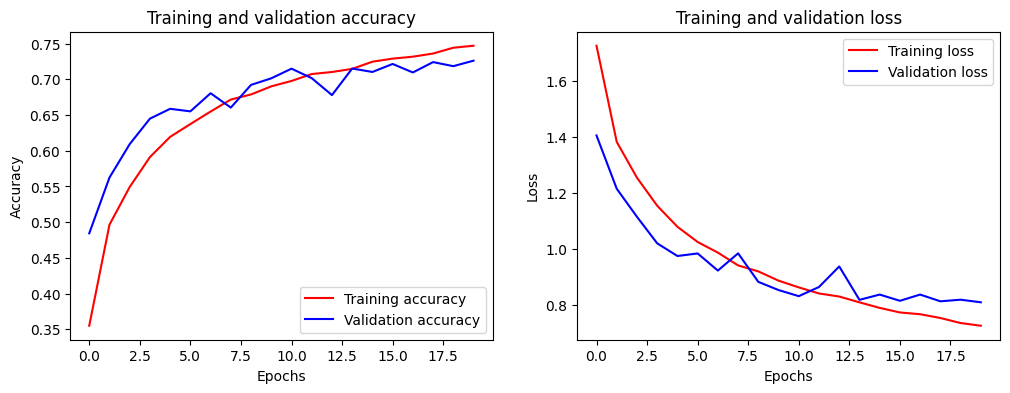

In [ ]:
# Visualizar la precisión y la pérdida a lo largo del entrenamiento
plot_training_history(cifar10_history)

In [ ]:
# Evaluar el modelo CIFAR-10
test_loss, test_acc = cifar10_model.evaluate(x_test_10, y_test_10, verbose=2)
print('\nCIFAR-10 accuracy:', test_acc)
print('\nCIFAR-10 loss:', test_loss)

313/313 - 1s - loss: 0.8100 - accuracy: 0.7261 - 1s/epoch - 3ms/step

CIFAR-10 accuracy: 0.7261000275611877

CIFAR-10 loss: 0.8099820017814636


#PREDICT

2/2 [==============================] - 0s 5ms/step


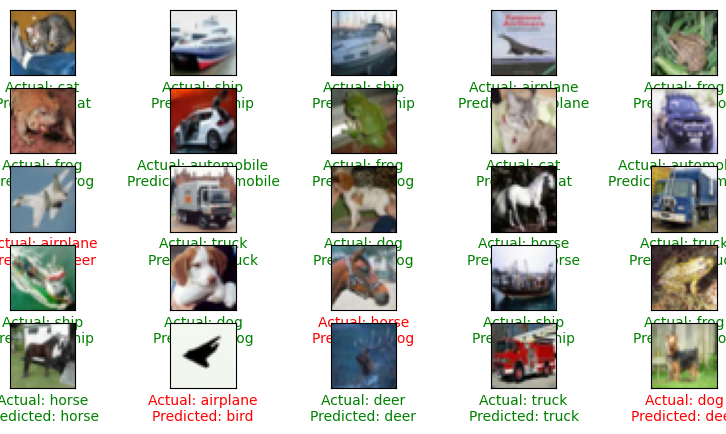

In [ ]:
# Mostrar ejemplos de imágenes de prueba junto con las etiquetas reales y las predicciones del modelo
num_examples = 50
test_images = x_test_10[:num_examples]
test_labels = y_test_10[:num_examples]
predictions = cifar10_model.predict(test_images)
show_examples(test_images, test_labels, predictions, cifar10_class_names)

# BUILD MODEL CIFAR100

In [9]:
# Crear el modelo CIFAR-100
cifar100_model = create_cnn100_model(x_train_100.shape[1:], 100)

In [10]:
# Compilar el modelo CIFAR-100
cifar100_model.compile(optimizer='adam',
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

In [11]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)

In [ ]:
final_dataset = datagen.flow(x_train_100, y_train_100, batch_size=64)

In [12]:
# Entrenar el modelo CIFAR-100
cifar100_history = cifar100_model.fit(datagen.flow(x_train_100, y_train_100), epochs=20, verbose=1, validation_data=(x_test_100, y_test_100))


Epoch 1/20
1563/1563 [==============================] - 128s 73ms/step - loss: 4.1407 - accuracy: 0.0119 - val_loss: 3.9804 - val_accuracy: 0.0015
Epoch 2/20
1563/1563 [==============================] - 111s 71ms/step - loss: 3.3515 - accuracy: 0.0111 - val_loss: 3.3605 - val_accuracy: 0.0023
Epoch 3/20
1563/1563 [==============================] - 112s 72ms/step - loss: 2.8265 - accuracy: 0.0109 - val_loss: 2.8234 - val_accuracy: 0.0122
Epoch 4/20
1563/1563 [==============================] - 113s 72ms/step - loss: 2.4422 - accuracy: 0.0109 - val_loss: 2.5679 - val_accuracy: 0.0040
Epoch 5/20
1563/1563 [==============================] - 112s 72ms/step - loss: 2.1724 - accuracy: 0.0109 - val_loss: 1.9751 - val_accuracy: 0.0088
Epoch 6/20
1563/1563 [==============================] - 112s 72ms/step - loss: 1.9665 - accuracy: 0.0104 - val_loss: 2.1636 - val_accuracy: 0.0063
Epoch 7/20
1563/1563 [==============================] - 112s 71ms/step - loss: 1.8004 - accuracy: 0.0106 - val_loss: 1

# EVALUATE MODEL CIFAR100

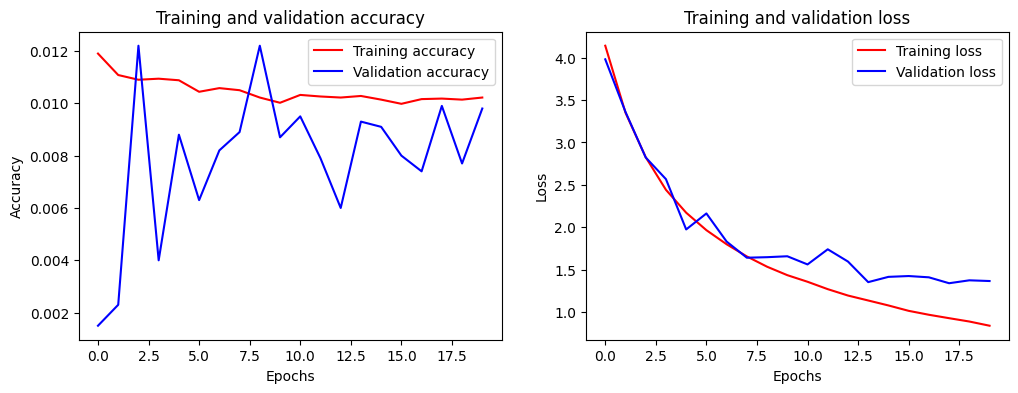

In [13]:
# Grafic the training history
plot_training_history(cifar100_history)

In [14]:
# Evaluar el modelo CIFAR-100
test_loss, test_acc = cifar100_model.evaluate(x_test_100, y_test_100, verbose=2)
print('\nCIFAR-100 accuracy:', test_acc)
print('\nCIFAR-100 loss:', test_loss)

313/313 - 5s - loss: 1.3671 - accuracy: 0.0098 - 5s/epoch - 16ms/step

CIFAR-100 accuracy: 0.009800000116229057

CIFAR-100 loss: 1.367051601409912


#PREDICT CIFAR100

2/2 [==============================] - 1s 1s/step


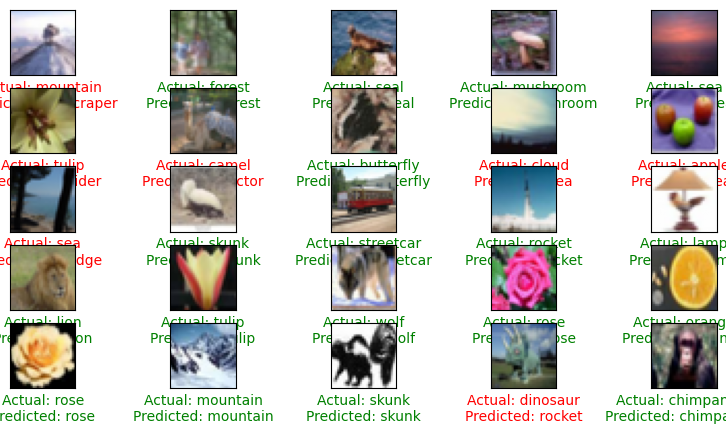

In [15]:
# Mostrar ejemplos de imágenes de prueba junto con las etiquetas reales y las predicciones del modelo
num_examples = 50
test_images = x_test_100[:num_examples]
test_labels = y_test_100[:num_examples]
predictions_100 = cifar100_model.predict(test_images)
show_examples(test_images, test_labels, predictions_100, cifar100_class_names)